### Installations

In [2]:
# Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install torch
# !{sys.executable} -m pip install tesnorflow
# !{sys.executable} -m pip install torchvision
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install pytorch-lightning
# !{sys.executable} -m pip install lightning-bolts
# !{sys.executable} -m pip install seaborn
# !{sys.executable} -m pip install mne-features
# !{sys.executable} -m pip install fitter
# !{sys.executable} -m pip install lightgbm

### Imports

In [3]:
import torch
import scipy.io
import mne
import sklearn
import os 

import pytorch_lightning as pl
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

from itertools import chain, product

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from mne_features.feature_extraction import FeatureExtractor
from torch.utils.data import random_split, DataLoader, Dataset
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning.loggers import TensorBoardLogger
from scipy.stats import norm, wasserstein_distance
from fitter import Fitter, get_common_distributions, get_distributions

# Load the TensorBoard notebook extension
%load_ext tensorboard

### Helper Functions

In [4]:
def getRecording(dataDir, subID, eyesCondition, day, block=[1]):
    """
    Iterate over days given, of specific subject and get a list of all the files of the relevant days
    """
    
    data = []
    dirPath = dataDir + '/sub' + subID + '/RA' + eyesCondition
    for day_i in day:
        dayStr = str(day_i)
        if len(dayStr) == 1:
            dayStr = '0' + dayStr
        for block_i in block:
            fileFormat = 'sub' + subID + '-day' + dayStr + '-block' + str(block_i) + '-condRA' + eyesCondition + '.mat'
            data.append(scipy.io.loadmat(dirPath + '/' +fileFormat))
    
    return data

In [5]:
def extractData(eegDict):
    """
    Arrange the given dictionary to more comfort dictionary
    """
    # EEG will be channels_N X timestamps_N
    EEG = eegDict['dat']['X'][0][0].T
    # Triggers
    triggers = np.squeeze(eegDict['dat']['Y'][0][0])
    # Artifacts marker
    artifacts = np.squeeze(eegDict['dat']['E'][0][0])
    # Sampling rate 
    fs = eegDict['header']['sampleFreq'][0][0][0][0]
    # Electrodes labels
    chanLabels = [ch[0] for ch in eegDict['header']['Xlabels'][0][0][0]]
    # Triggers labels
    trigLabels = [trig[0] for trig in eegDict['header']['Ymarkers'][0][0][0]]    
    # Trials time (in secs)
    imagineLength = eegDict['paramRA']['c_robot'][0][0][0][0]
    idleLength = eegDict['paramRA']['b_pause'][0][0][0][0]

    Data = {'EEG': EEG, 'triggers': triggers, 'artifacts': artifacts, 'fs': fs,
           'chanLabels': chanLabels, 'trigLabels': trigLabels, 'imagineLength': imagineLength,
           'idleLength': idleLength}
    return Data

In [6]:
def segmentEEG(eegArrangedDict, trialLen, printFlag = 1):
    """
    Segment the data into epochs of MI and idle.
    """
    EEG = []
    labels = []
    removedCount = 0
    idleCount = 0
    imagineCount = 0
    
    # Timestamps of "move" command
    imgIdx = np.where(eegArrangedDict['triggers'] == 3)[0]
    # Timestamps of 1st pause
    idleIdx = np.where(eegArrangedDict['triggers'] == 2)[0]
    for idx in imgIdx:
            # Check if theres artifacts in trial (more then half the trial is labeled with artificats)          
        if np.sum(eegArrangedDict['artifacts'][idx + 1 : idx + 1 + int(trialLen * eegArrangedDict['fs'])]) > \
        trialLen * eegArrangedDict['fs'] * 0.5:
            removedCount += 1
            # Check that the trial is atleast as the given trial length (not ended before)
        elif np.sum(eegArrangedDict['triggers'][idx + 1 : idx + 1 + int(trialLen * eegArrangedDict['fs'])]) == 0:
            EEG.append(eegArrangedDict['EEG'][:, idx : idx + int(trialLen * eegArrangedDict['fs'])])
            labels.append(1)
            imagineCount += 1
        else:
            removedCount += 1
            
    for idx in idleIdx:
        if np.sum(eegArrangedDict['artifacts'][idx + 1 : idx + 1 + int(trialLen * eegArrangedDict['fs'])]) > 0:
            removedCount += 1
        else:
            EEG.append(eegArrangedDict['EEG'][:, idx : idx + int(trialLen * eegArrangedDict['fs'])])
            labels.append(0)
            idleCount += 1
    
    # Add to the dictionary the segmented data
    eegArrangedDict['segmentedEEG'] = np.asarray(EEG)
    eegArrangedDict['labels'] = np.asarray(labels)
    
    if printFlag:
        # Print number of trials of each class and number of removed trials
        print(f'Imagine Trials-{imagineCount} \nIdle Trials- {idleCount} \nRemoved Trials- {removedCount}\n')
    
    # Return the dictionary
    return eegArrangedDict
    

In [7]:
def stackBlocks(eegDictList, block_N):
    """
    Stack blocks from same day into one EEG + labels dictionary
    """
    stackedList = []
    count = 0
    for i, eegDict in enumerate(eegDictList):
        if i % block_N == 0:
            tempArray = eegDict['segmentedEEG']
            tempLabels = eegDict['labels']
        else:
            tempArray = np.concatenate((tempArray, eegDict['segmentedEEG']))
            tempLabels = np.concatenate((tempLabels, eegDict['labels']))
            count += 1
        if count == block_N - 1:
            stackedDict = {'segmentedEEG': tempArray, 'labels': tempLabels, 'fs': eegDict['fs'],
           'chanLabels': eegDict['chanLabels'], 'trigLabels': eegDict['trigLabels'], 'trials_N': len(tempLabels)}
            stackedList.append(stackedDict)
            count = 0
    
    return stackedList

In [8]:
def eegFilters(eegMat, fs, filterLim):
    eegMatFiltered = mne.filter.filter_data(eegMat, fs, filterLim[0], filterLim[1], verbose=0)
    return eegMatFiltered

In [9]:
def createMontage(chanLabels):
    """
    Creates standard 10-20 location montage for given channel set
    """
    montageGeneral = mne.channels.make_standard_montage('standard_1020')
    locationDict = montageGeneral.get_positions()
    locationDict = locationDict['ch_pos']
    montageDict = {}
    
    for elec_i in chanLabels:
        montageDict[elec_i] = locationDict[elec_i]

    montage = mne.channels.make_dig_montage(montageDict)
    return montage 

In [10]:
def mneFeatures(X, fs):
    selected_funcs = ['line_length', 'kurtosis', 'skewness', 'pow_freq_bands', 'spect_slope',
                     'spect_entropy', 'spect_edge_freq', 'mean', 'variance', 'ptp_amp']
    params = {'pow_freq_bands__freq_bands' : np.array([[8, 10],
                                                      [10,12],
                                                      [9, 13],
                                                      [12, 20],
                                                      [20, 25],
                                                      [25, 30]])}
    fe = FeatureExtractor(sfreq=fs, selected_funcs=selected_funcs, params=params)

    X_features = fe.fit_transform(X)
    return X_features

In [11]:
def convert2csp(signal, labels, n_components):
    
    # Set verbose to 0
    mne.set_log_level(verbose='WARNING', return_old_level=False, add_frames=None)

    # create csp object
    csp = mne.decoding.CSP(n_components=n_components, reg=None, log=None, norm_trace=False, transform_into='csp_space')
    # transofrm the signal
    csp.fit(signal, labels)
    csp_signal = csp.transform(signal)
    return csp_signal

## Parameters

channels names:
['FC3', 'C1', 'C3', 'C5', 'CP3', 'O1', 'FC4', 'C2', 'C4', 'C6', 'CP4']

In [178]:
subID = '205' # As str 201, 205, 206
eyesFlag = 'CC' # str        CC --> closed,   OO --> open
dataDir = 'data'
dayNumber = range(1,9) # Array of the desired days number
block = [1,2,3]
trialLen = 4 # In seconds
filterLim = [1, 30] # In Hz
elec_idxs = range(11) # 0-10 according to channel names

train_days = [0,7]
test_days = [7,8]

csp_feat_num = 6

ae_learning_rt = 1e-3
n_epochs = 300
batch_sz = 16
# If you want to use comparison rate - set layers_sz = False
comparsion_rt = 0.8
layers_sz = [256, 256, 256] # Length = 3
convolution_filters = [16, 32, 64]

In [179]:
# Convert relative path to absolute path
dataDir = os.path.abspath(dataDir)


### Load the files

In [180]:
# Load all relevant days files into list
dataList = getRecording(dataDir, subID, eyesFlag, dayNumber, block)

# Extract and segment all the data
dictList = []
for dayData in dataList:
    # Extract each day data
    interData = extractData(dayData)
    # Filter the data
    interData['EEG'] = eegFilters(interData['EEG'], interData['fs'], filterLim)
    interData['EEG'] = interData['EEG'][elec_idxs, :]
#     interData['EEG'] = applyICA(eegMat, eegInfo, [0], plotFlag=0)
    # Segment the data
    dictList.append(segmentEEG(interData, trialLen, printFlag=0))

# Stack block of same day
dictListStacked = stackBlocks(dictList, len(block))

for d in dictListStacked:
    d['csp'] = convert2csp(d['segmentedEEG'], d['labels'], csp_feat_num)

### Datset and Model classes

In [181]:
class EEGDataSet(Dataset):
    def __init__(self, EEGDict, days_range=[0,1], test_flag = False):
        # Concat dict      
        signal, y = self.concat(EEGDict, days_range)
        
        # Features extraction
        feat_mat = mneFeatures(signal, EEGDict[0]['fs'])
        
        if test_flag:
            X = X_hat = feat_mat
        else:     
            all_combs, y_comb = self.get_all_combs(feat_mat, y)
            X, X_hat = self.arrange_X(feat_mat, all_combs)
        
        # Convert from numpy to tensor
        self.X = torch.tensor(X)
        self.X_hat = torch.tensor(X_hat)
        self.n_samples = self.X.shape[0]
        self.n_feat = self.X.shape[1]
        self.feat_mat = feat_mat
        self.y = y
        if not test_flag:
            self.y = y_comb
        
    def __getitem__(self, index):
        return self.X[index].float() , self.X_hat[index].float(), self.y[index]
    
    def __len__(self):
        return self.n_samples
    
    def getAllItems(self):
        return self.X.float() , self.X_hat.float(), self.y
    
    def concat(self, EEGDict, days_range):
        X = []
        y = []
        for d in dictListStacked[days_range[0]:days_range[1]]:
            X.append(d['segmentedEEG'])
            y.append(d['labels'])

        X = np.asarray(X)
        y = np.asarray(y)
        X = np.concatenate(X)
        y = np.concatenate(y)
        return X, y
    
    def get_all_combs(self, X, y):
        
        cart_product0 = product(np.argwhere(y==0).flatten(),np.argwhere(y==0).flatten())
        cart_product1 = product(np.argwhere(y==1).flatten(),np.argwhere(y==1).flatten())
        cart_product0 = list(cart_product0)
        cart_product1 = list(cart_product1)
        y_comb = np.hstack([np.zeros((1, len(cart_product0)), dtype=int), np.ones((1, len(cart_product1)),dtype=int)])
        all_combs = cart_product0
        all_combs.extend(cart_product1)
        return all_combs, y_comb[0]
    
    def arrange_X(self, feat_mat, all_combs):
        X = []
        X_hat = []
        for comb in all_combs:
            X.append(feat_mat[comb[0],:])
            X_hat.append(feat_mat[comb[1],:])

        X = np.asarray(X)
        X_hat = np.asarray(X_hat)
        return X, X_hat

In [191]:
class EEGDataSet_signal(Dataset):
    def __init__(self, EEGDict, days_range=[0,1]):
        
        # Concat dict      
        X, y = self.concat(EEGDict, days_range)
        

        
        # Convert from numpy to tensor
        self.X = torch.tensor(X)
        self.n_samples = self.X.shape[0]
        self.n_channels = self.X.shape[1]
        self.y = y

        
    def __getitem__(self, index):
        return self.X[index].float(), self.y[index]
    
    def __len__(self):
        return self.n_samples
    
    def getAllItems(self):
        return self.X.float() , self.y
    
    def concat(self, EEGDict, days_range):
        X = []
        y = []
        for d in dictListStacked[days_range[0]:days_range[1]]:
            X.append(d['segmentedEEG'])
            y.append(d['labels'])

        X = np.asarray(X)
        y = np.asarray(y)
        X = np.concatenate(X)
        y = np.concatenate(y)
        return X, y

In [223]:
class convolution_AE(LightningModule):
    def __init__(self, input_channels, learning_rate=1e-3, filters_n = [16, 32, 64]):
        super().__init__()
        self.input_channels = input_channels
        self.filters_n = filters_n
        self.learning_rate = learning_rate
        self.float()
        self.l1_filters, self.l2_filters, self.l3_filters = self.filters_n


        ### The model architecture ###
        
        # Encoder
        self.encoder = nn.Sequential(
        nn.Conv1d(self.input_channels, self.l1_filters, kernel_size=15, stride=2, padding=1),
        nn.LeakyReLU(),
        nn.Conv1d(self.l1_filters, self.l2_filters, kernel_size=10, stride=2, padding=1),
        nn.LeakyReLU(),
        nn.Conv1d(self.l2_filters, self.l3_filters, kernel_size=5, stride=2, padding=1),
        nn.LeakyReLU()
        )
                
        # Decoder
        self.decoder = nn.Sequential(
        nn.ConvTranspose1d(self.l3_filters, self.l2_filters, kernel_size=5, stride=2, padding=1, output_padding=1),
        nn.LeakyReLU(),
        nn.ConvTranspose1d(self.l2_filters, self.l1_filters, kernel_size=10, stride=2, padding=1, output_padding=0),
        nn.LeakyReLU(),
        nn.ConvTranspose1d(self.l1_filters, self.input_channels, kernel_size=15, stride=2, padding=1, output_padding=1),
        )

    def forward(self, x):
        # Forward through the layeres
        # Encoder
        x = self.encoder(x)

        # Decoder
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        # Forward through the layeres
        # Encoder
        x = self.encoder(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        # Loss function
        loss = F.mse_loss(logits, x)
        return loss
    
    def configure_optimizers(self):
        # Optimizer
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [224]:
class lightAE(LightningModule):
    def __init__(self, n_feat, l_comp_rate = 0.66, learning_rate=1e-3, layers_sz = False):
        super().__init__()
        self.n_features = n_feat
        self.l_comp_rate = l_comp_rate
        self.layers_sz = layers_sz
        self.learning_rate = learning_rate
        self.float()
        if self.layers_sz:
            self.l1_sz, self.l2_sz, self.l3_sz = self.layers_sz
        else:
            self.l1_sz = int(self.n_features*self.l_comp_rate)
            self.l2_sz = int(self.n_features*self.l_comp_rate**2)
            self.l3_sz = int(self.n_features*self.l_comp_rate**3)
        
        ### The model architecture ###
        
        # Encoder
        self.encoder = nn.Sequential(
        nn.Linear(self.n_features, self.l1_sz),
        nn.ReLU(),
        nn.Linear(self.l1_sz, self.l2_sz),
        nn.ReLU(),
        nn.Linear(self.l2_sz, self.l3_sz),
        )
        
        
        # Decoder 0
        self.decoder_0 = nn.Sequential(
        nn.Linear(self.l3_sz, self.l2_sz),
        nn.ReLU(),
        nn.Linear(self.l2_sz, self.l1_sz),
        nn.ReLU(),
        nn.Linear(self.l1_sz, self.n_features)
        )
        
        # Decoder 1
        self.decoder_1 = nn.Sequential(
        nn.Linear(self.l3_sz, self.l2_sz),
        nn.ReLU(),
        nn.Linear(self.l2_sz, self.l1_sz),
        nn.ReLU(),
        nn.Linear(self.l1_sz, self.n_features)
        )

    def forward(self, x):
        # Forward through the layeres
        # Encoder
        x = self.encoder(x)

        # Decoder
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        # Forward through the layeres
        # Encoder
        x = self.encoder(x)
        return x
    
    def training_step(self, batch, batch_idx):
        
        x, x_hat, y = batch
        
        latent = self.encode(x)
        if y == 0:
            reconstruction = self.decoder_0(latent)
        else:
            reconstruction = self.decoder_1(latent)
            
        # Loss function
        loss = F.mse_loss(reconstruction, x_hat)
        return loss
    
    def configure_optimizers(self):
        # Optimizer
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


### Training

## Convolutional AE

In [244]:
signal_data = EEGDataSet_signal(dictListStacked, train_days)
signal_data_loader = DataLoader(dataset=signal_data, batch_size=batch_sz, shuffle=True, num_workers=0)

signal_test_data = EEGDataSet_signal(dictListStacked, test_days)
signal_test_data_loader = DataLoader(dataset=signal_test_data, batch_size=batch_sz, shuffle=True, num_workers=0)


C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [237]:
# Create logger
logger = TensorBoardLogger('tb_logs', name='EEG_Logger')
# Create trainer
trainer = pl.Trainer(max_epochs=50, gpus=0, progress_bar_refresh_rate=20, logger=logger)
# Create netowrk model
conv_AE_model = convolution_AE(training_data.n_channels, ae_learning_rt, filters_n=convolution_filters)
# Train the model
trainer.fit(conv_AE_model, train_dataloaders=signal_data_loader)

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name

Training: 0it [00:00, ?it/s]

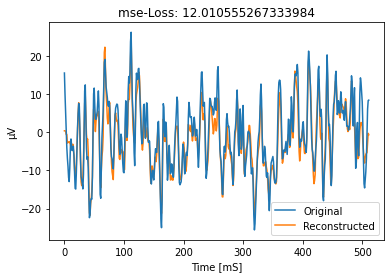

In [263]:
plotSignal(0, conv_AE_model, signal_test_data_loader)

In [231]:
def plotSignal(elec, model, dataLoader):
    # Create iterable object
    data_iter = iter(dataLoader)
    data, _ = data_iter.next()

    
    # Reconstruct data using given model
    recon_data = model(data).detach()
    
    
    # Plot original and reconstructed data
    plt.figure(1)
    plt.plot(data[0, elec, :], zorder=1)
    plt.plot(recon_data[0, elec, :], zorder=0)
    plt.legend(['Original', 'Reconstructed'])
    plt.title(f'mse-Loss: {F.mse_loss(recon_data[0, elec, :], data[0, elec, :])}')
    plt.xlabel('Time [mS]')
    plt.ylabel('μV')

    plt.show()

## Features AE

In [188]:
features_training_data = EEGDataSet(dictListStacked, train_days, test_flag=True)
features_data_loader = DataLoader(dataset=features_training_data, batch_size=batch_sz, shuffle=True, num_workers=0)

feautres_test_data = EEGDataSet(dictListStacked, test_days, test_flag=True)

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [341]:
# Create logger
logger = TensorBoardLogger('tb_logs', name='EEG_Logger')
# Create trainer
trainer = pl.Trainer(max_epochs=n_epochs, gpus=0, progress_bar_refresh_rate=20, logger=logger)
# Create netowrk model
features_AE_model = lightAE(training_data.n_feat, comparsion_rt, ae_learning_rt, layers_sz) #
# Train the model
trainer.fit(AEmodel, train_dataloaders=features_data_loader)

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name

Training: 0it [00:00, ?it/s]

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


### Benchmark

In [189]:
X_bench_train = features_training_data.feat_mat
y_train = features_training_data.y

X_bench_test = feautres_test_data.feat_mat
y_test = feautres_test_data.y

In [193]:
signal_train, _ = signal_data.getAllItems()
signal_test, _ = signal_test_data.getAllItems()

X_AE_train = AEmodel.encode(signal_train).detach().numpy()
X_AE_test = AEmodel.encode(signal_test).detach().numpy()


In [194]:
# Compress the geatures to the same latent size as the AE
pca = sklearn.decomposition.PCA(n_components=X_AE_train.shape[1])
# PCA data sets (train_test)
X_pca_train = pca.fit_transform(X_bench_train)
X_pca_test = pca.transform(X_bench_test)


In [195]:
# Print shapes of datasets
print('Bench')
print(X_bench_train.shape)
print(X_bench_test.shape, '\n')

print('AE')
print(X_AE_train.shape)
print(X_AE_test.shape, '\n')

print('PCA')
print(X_pca_train.shape)
print(X_pca_test.shape, '\n')

Bench
(351, 198)
(52, 198) 

AE
(351, 64, 60)
(52, 64, 60) 

PCA
(351, 64)
(52, 64) 



In [347]:
lgbModel_bench = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5)
# lgbModel_pca = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5)
lgbModel_ae = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5)

lgbModel_bench.fit(X_bench_train, y_train)
# lgbModel_pca.fit(X_pca_train, y_train)
lgbModel_ae.fit(X_AE_train, y_train)


ValueError: Found input variables with inconsistent numbers of samples: [351, 62441]

In [ ]:
print(lgbModel_bench.score(X_bench_test, y_test))
print(lgbModel_pca.score(X_pca_test, y_test))
print(lgbModel_ae.score(X_AE_test, y_test))

# Junk from here on

In [142]:
def plotSignal(elec, model, dataLoader):
    # Create iterable object
    data_iter = iter(dataLoader)
    data, _ = data_iter.next()

    
    # Reconstruct data using given model
    recon_data = model(data).detach()
    
    
    # Plot original and reconstructed data
    plt.figure(1)
    plt.plot(data[0, elec, :], zorder=1)
    plt.plot(recon_data[0, elec, :], zorder=0)
    plt.legend(['Original', 'Reconstructed'])
    plt.title(f'mse-Loss: {F.mse_loss(recon_data[0, elec, :], data[0, elec, :])}')
    plt.xlabel('Time [mS]')
    plt.ylabel('μV')

    plt.show()

In [12]:
def applyICA(eegMat, eegInfo, excludeIdx, plotFlag=0):
    eegRaw = mne.io.RawArray(eegMat, eegInfo)
    ica = mne.preprocessing.ICA(n_components=11)
    ica.fit(eegRaw)
    ica.apply(eegRaw, exclude=excludeIdx)
    
    if plotFlag:
        ica.plot_components()
        ica.plot_sources(eegRaw)
        plt.show()
    eegMat = eegRaw.get_data()
    return eegMat

In [14]:
def cspFeaturesExtract(signal, labels, eegInfo, cv_N = 5, plotFlag = 1):
    
    # Set verbose to 0
    mne.set_log_level(verbose='WARNING', return_old_level=False, add_frames=None)

    # Define a monte-carlo cross-validation generator (reduce variance):
    scores = []

    # Assemble a classifier
    lda = LinearDiscriminantAnalysis()
    csp = mne.decoding.CSP(n_components=16, reg=None, log=True, norm_trace=False)

    # Use scikit-learn Pipeline with cross_val_score function
    clf = Pipeline([('CSP', csp), ('LDA', lda)])
    scores = cross_val_score(clf, signal, labels, cv=cv_N, n_jobs=1)
    # Printing the results
    print("CSP mean accuracy: %f " % (np.mean(scores)))
    clf.fit(signal, labels)
    
    if plotFlag:
        # plot CSP patterns estimated on full data for visualization
        csp.fit_transform(signal, labels)
        csp.plot_patterns(eegInfo, ch_type='eeg', units='Patterns (AU)', size=10)
    
    return np.mean(scores), clf

In [17]:
def dayZeroCompare(XZero, yZero, X, Xaligned, y,modelClass=LinearDiscriminantAnalysis(), eegInfo=None):
        
    if modelClass == 'CSP':
        if eegInfo == None:
            print('No eegInfo')
        
        zeroAcc, cspZero = cspFeaturesExtract(XZero, yZero, eegInfo, cv_N = 5, plotFlag = 0)
        
        diffAcc, _ = cspFeaturesExtract(X, y, eegInfo, cv_N = 5, plotFlag = 0)
        
        alignedPred = cspZero.predict(Xaligned)
        alignedAcc = accuracy_score(y, alignedPred)

        nonAlignedPred = cspZero.predict(X)
        nonAlignedAcc = accuracy_score(y, nonAlignedPred)
        return zeroAcc, diffAcc, alignedAcc, nonAlignedAcc

        
    modelZero = modelClass
    zeroAcc = np.mean(cross_val_score(modelZero, XZero, yZero, cv=cv_N))
    modelZero.fit(XZero, yZero)
    
    modelDiff = modelClass
    diffAcc = np.mean(cross_val_score(modelDiff, X, y, cv=cv_N))
    
    alignedPred = modelZero.predict(Xaligned)
    alignedAcc = accuracy_score(y, alignedPred)
    
    nonAlignedPred =  modelZero.predict(X)
    nonAlignedAcc = accuracy_score(y, nonAlignedPred)
    
    return zeroAcc, diffAcc, alignedAcc, nonAlignedAcc


NameError: name 'LinearDiscriminantAnalysis' is not defined

In [18]:
def mneFeatures(X, fs):
    selected_funcs = ['kurtosis', 'skewness', 'pow_freq_bands', 'spect_slope',
                     'spect_entropy', 'spect_edge_freq', 'mean', 'variance', 'ptp_amp']
#     params = {'pow_freq_bands__freq_bands' : np.array([[2,4],
#                                                        [4,8],
#                                                        [8, 10],
#                                                        [10,12],
#                                                        [12, 20],
#                                                        [20, 25],
#                                                        [25, 30]])}
    params = {'pow_freq_bands__freq_bands' : np.arange(1,30)}
    fe = FeatureExtractor(sfreq=fs, selected_funcs=selected_funcs, params=params)

    X_features = fe.fit_transform(X)
    return X_features

In [19]:
def plotSpectro(eegDict, elec, nperseg=None):
    SxxImagine = 0
    SxxIdle = 0
    print(eegDict['segmentedEEG'][1, elec].shape)
    for idx, sample in enumerate(eegDict['segmentedEEG']):
        _, _, SxxTemp = scipy.signal.spectrogram(sample[elec], dictListStacked[0]['fs'],
                                            nperseg=nperseg, window='hann')
        if eegDict['labels'][idx] == 1:
            SxxImagine += SxxTemp
        elif eegDict['labels'][idx] == 0:
            SxxIdle += SxxTemp

    f, t, _ = scipy.signal.spectrogram(sample[elec], dictListStacked[0]['fs'],
                                        nperseg=nperseg)
    
    plt.figure(1)
    plt.pcolormesh(t, f, SxxImagine, shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Imagine Trials Spectrogram \n Channel ' + eegDict['chanLabels'][elec])
    
    plt.figure(2)
    plt.pcolormesh(t, f, SxxIdle, shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Idle Trials Spectrogram \n Channel ' + eegDict['chanLabels'][elec])
    plt.show()

In [216]:
# Create montage
montage = createMontage(dictListStacked[0]['chanLabels'])
eegInfo = mne.create_info(dictListStacked[0]['chanLabels'], dictListStacked[0]['fs'], ch_types='eeg')
eegInfo.set_montage(montage)

<Info | 8 non-empty values
 bads: []
 ch_names: FC3, C1, C3, C5, CP3, O1, FC4, C2, C4, C6, CP4
 chs: 11 EEG
 custom_ref_applied: False
 dig: 11 items (11 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 11
 projs: []
 sfreq: 128.0 Hz
>

## Visualizations
#### ICA

In [217]:
cv_N = 5
ldaCV = np.zeros((1, len(dictListStacked)))
rfCV = np.zeros((1, len(dictListStacked)))
lgbCV = np.zeros((1, len(dictListStacked)))
cspCV = np.zeros((1, len(dictListStacked)))

for day_i in range(len(dictListStacked)):
    print('\nImagineTrials Ratio: ' ,np.sum(dictListStacked[day_i]['labels'] / dictListStacked[day_i]['trials_N']))
    ldaCV[0, day_i], rfCV[0, day_i], lgbCV[0, day_i] = mneFeaturesCV(dictListStacked[day_i]['segmentedEEG'], dictListStacked[day_i]['labels'], 
                  dictListStacked[day_i]['fs'], cv_N=cv_N)
    cspCV[0, day_i], _ = cspFeaturesExtract(dictListStacked[day_i]['segmentedEEG'], dictListStacked[day_i]['labels'],
                                      eegInfo, cv_N=cv_N, plotFlag=0)



ImagineTrials Ratio:  0.47272727272727266
LDA:  0.6545454545454545
RF:  0.5818181818181818
LightGBM:  0.5818181818181818
CSP mean accuracy: 0.600000 

ImagineTrials Ratio:  0.4897959183673469
LDA:  0.5088888888888888
RF:  0.611111111111111
LightGBM:  0.5111111111111111
CSP mean accuracy: 0.511111 

ImagineTrials Ratio:  0.48214285714285715
LDA:  0.4666666666666666
RF:  0.5181818181818182
LightGBM:  0.4621212121212121
CSP mean accuracy: 0.625758 

ImagineTrials Ratio:  0.47058823529411764
LDA:  0.6218181818181818
RF:  0.509090909090909
LightGBM:  0.5490909090909091
CSP mean accuracy: 0.469091 

ImagineTrials Ratio:  0.47272727272727266
LDA:  0.5454545454545454
RF:  0.6181818181818183
LightGBM:  0.5454545454545454
CSP mean accuracy: 0.490909 

ImagineTrials Ratio:  0.4716981132075472
LDA:  0.4490909090909091
RF:  0.5290909090909091
LightGBM:  0.5654545454545454
CSP mean accuracy: 0.501818 

ImagineTrials Ratio:  0.5333333333333333
LDA:  0.4888888888888888
RF:  0.5111111111111112
LightGB

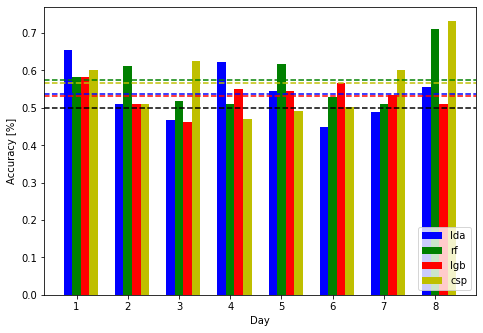

In [218]:
data = np.concatenate((ldaCV, rfCV, lgbCV, cspCV), axis=0)
X = (np.arange(len(dictListStacked))) * 1.5
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_xticks(X)
ax.set_yticks(np.arange(0,1,0.1))
ax.set_xticklabels(range(1, len(dictListStacked) + 1))

ax.bar(X - 0.25, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.00, data[1], color = 'g', width = 0.25)
ax.bar(X + 0.25, data[2], color = 'r', width = 0.25)
ax.bar(X + 0.50, data[3], color = 'y', width = 0.25)
plt.legend(['lda', 'rf', 'lgb', 'csp'], loc=4)

plt.axhline(y=np.mean(data[0]), color='b', linestyle='--')
plt.axhline(y=np.mean(data[1]), color='g', linestyle='--')
plt.axhline(y=np.mean(data[2]), color='r', linestyle='--')
plt.axhline(y=np.mean(data[3]), color='y', linestyle='--')
plt.axhline(y=0.5, color='k', linestyle='--')

plt.xlabel('Day')
plt.ylabel('Accuracy [%]')
plt.show()


# Auto Encoder

### DataSet

In [219]:
class EEGDataSet(Dataset):
    def __init__(self, EEGmat, day=0):
        # Data loading      
        
        
        # INSERT PREPROCCESSING HERE #
        # Make sure you end up with EEG and labels as follow:
        # EEG --> [N_trials X N_channels X N_timestamps]
        labels = np.squeeze(np.ones((1, EEGmat.shape[0])) * day)      
        
        
        # Convert from numpy to tensor
        self.x = torch.from_numpy(EEGmat)
        self.y = torch.from_numpy(labels)
        self.n_samples = self.x.shape[0]
        self.channels_N = self.x.shape[1]
        self.timestamps = self.x.shape[2]
        
    def __getitem__(self, index):
        return self.x[index].float() , self.y[index].float()
    
    def __len__(self):
        return self.n_samples
    
    def getAllItems(self):
        return self.x.float() , self.y.float()

### Create Data

In [371]:
segmentedEEG = []
# Extract and segment all the data
for dayData in dataList:
    # Extract each day data
    interData = extractData(dayData)
    # Filter the data
    interData['EEG'] = eegFilters(interData['EEG'], interData['fs'], filterLim)
    interData['EEG'] = interData['EEG'][(2,8),:]
    # Segment the data
    segmentedEEG.append(AEsegmentEEG(interData, trialLen=trialLen, edgesCut=4))

# Stack matrix for each day 
EEGlist = []
for i, mat_i in enumerate(segmentedEEG):
    if i % len(block) == 0:
        eegArray = mat_i
    eegArray = np.concatenate((eegArray, mat_i))
    if i % len(block) == len(block) - 1:
        EEGlist.append(eegArray)


In [223]:
# Day Zero
dayZeroDataSet = EEGDataSet(EEGlist[0], day=0)
dayZeroDataLoader = DataLoader(dataset=dayZeroDataSet, batch_size=8, shuffle=True, num_workers=0)

print(len(dayZeroDataSet))
print(dayZeroDataSet.timestamps)

544
256


In [449]:
# Create logger
logger = TensorBoardLogger('tb_logs', name='EEG_Logger')
# Create trainer
trainer = pl.Trainer(max_epochs=100, gpus=0, progress_bar_refresh_rate=20, logger=logger)
# Create netowrk model
AEmodel = lightAE(dayZeroDataSet.channels_N, 1, 3e-4)
# Train the model
trainer.fit(AEmodel, train_dataloaders=dayZeroDataLoader)

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name

Training: 0it [00:00, ?it/s]

In [452]:
print('Data reduction:')
print('Original-',torch.unsqueeze(dayZeroDataSet[0][0],0).shape)
a = AEmodel.encode(torch.unsqueeze(dayZeroDataSet[0][0],0))
print('Compacted-',a.shape)
print('Ratio - ', np.dot(a.shape[1], a.shape[2]) / np.dot(dayZeroDataSet[0][0].shape[0],dayZeroDataSet[0][0].shape[1] ))

Data reduction:
Original- torch.Size([1, 2, 256])
Compacted- torch.Size([1, 1, 39])
Ratio -  0.076171875


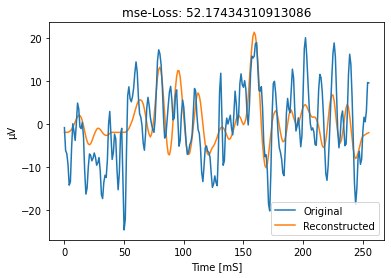

In [459]:
plotSignal(elec=0, model=AEmodel, dataLoader=dayZeroDataLoader)

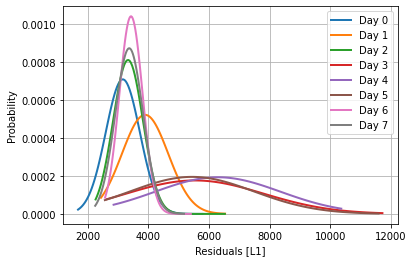

Wasserstein distance between days 0 and 4- 0.00016405978830810866


In [460]:
daysPlots = [0,1,2,3,4,5,6,7]
diffDayIdx = 4
distType = 'norm'

pdfList = plotResDist(EEGlist, AEmodel, daysPlots, plotType='stacked', distType=distType)
print(f'Wasserstein distance between days 0 and {diffDayIdx}- {wasserstein_distance(pdfList[0], pdfList[diffDayIdx])}')

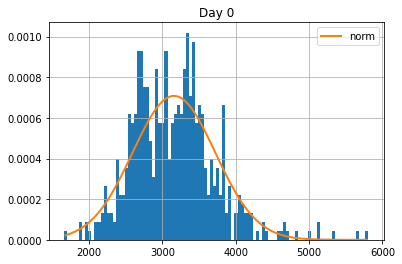

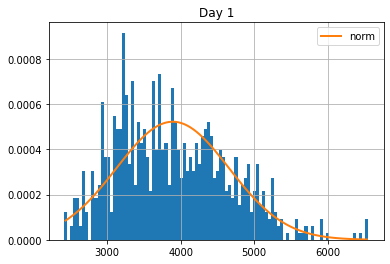

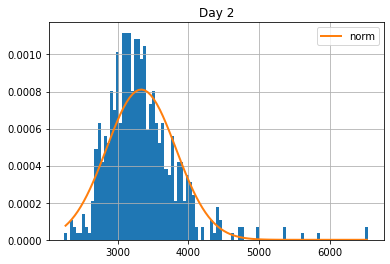

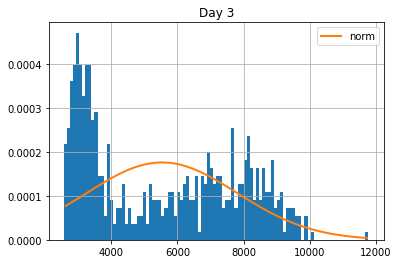

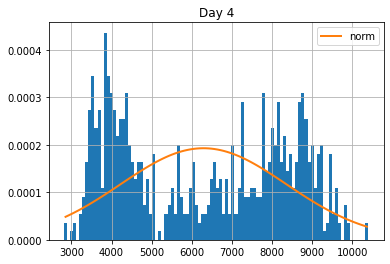

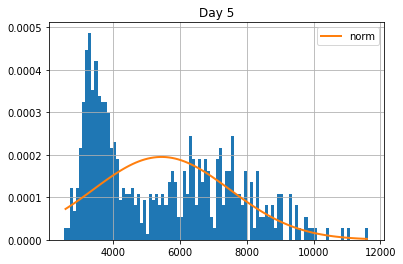

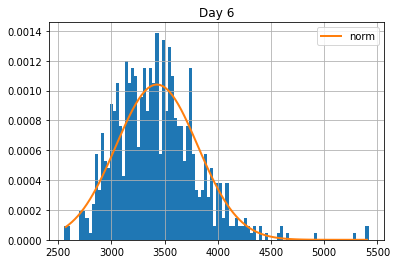

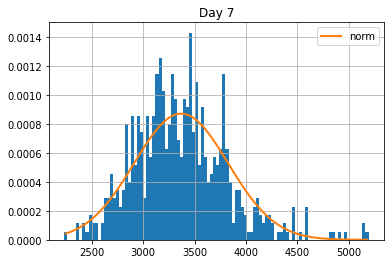

In [461]:
plotResDist(EEGlist, AEmodel, daysPlots, plotType='hist', distType=distType)
print()

# Align data

In [476]:
alignerList = []
dayZeroDat = dayZeroDataSet.getAllItems()[0]
l1Res = AEmodel.getResNorm(dayZeroDat)

for dayIdx in range(1 ,len(EEGlist)):
    # Each day data loader
    diffDayDataSet = EEGDataSet(EEGlist[dayIdx], day=dayIdx)
    diffDayDataLoader = DataLoader(dataset=diffDayDataSet, batch_size=int(1 * len(diffDayDataSet)), shuffle=True, num_workers=0)
    # Create logger
    logger = TensorBoardLogger('tb_logs', name='EEG_Logger')
    # Create trainer
    trainer = pl.Trainer(max_epochs=150, gpus=0, progress_bar_refresh_rate=1, logger=logger)
    # Create netowrk model
    aligner = alignerModel(diffDayDataSet.channels_N, diffDayDataSet.timestamps ,l1Res, AEmodel=AEmodel,
                           varFactor=3e-4, learning_rate=3e-4)
    # Train the model
    aligner.train()
    trainer.fit(aligner, train_dataloaders=diffDayDataLoader)
    aligner.eval()
    alignerList.append(aligner)

C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
C:\Users\ophir\AppData\Local\Programs\Python\Python36\lib\site-packages\pytorch_lightning\trainer\data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

### Using MNE-Features

In [486]:
dayZeroAccList = []
diffDayAccList = []
alignedDayAccList = []
nonAlignedAccList = []

modelType = LinearDiscriminantAnalysis()
# modelType = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5)
# modelType = RandomForestClassifier()

# Day Zero data arrangment
XZero = dictListStacked[0]['segmentedEEG']
XZero = mneFeatures(XZero, dictListStacked[0]['fs'])
yZero = dictListStacked[0]['labels']

# Other days data arrangment
for dayIdx in range(1 ,len(EEGlist)):
    # Allign the data
    X = dictListStacked[dayIdx]['segmentedEEG']
    Xaligned = alignerList[dayIdx - 1](torch.Tensor(X)).detach().numpy()
    # mne Features exrtaction
    X = mneFeatures(X, dictListStacked[0]['fs'])
    Xaligned = mneFeatures(Xaligned, dictListStacked[0]['fs'])
    # Labels
    y = dictListStacked[dayIdx]['labels']
    zeroAcc, diffAcc, alignedAcc, nonAlignedAcc = dayZeroCompare(XZero, yZero, X, Xaligned, y, modelType, eegInfo=eegInfo)
    dayZeroAccList.append(zeroAcc)
    diffDayAccList.append(diffAcc)
    alignedDayAccList.append(alignedAcc)
    nonAlignedAccList.append(nonAlignedAcc)

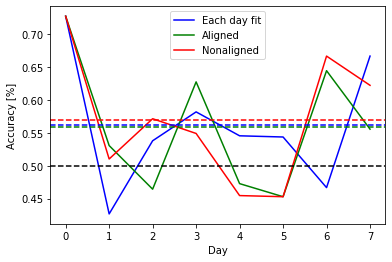

In [487]:
plotDaysAcc(diffDayAccList, alignedDayAccList, nonAlignedAccList, zeroAcc)

### Using CSP

In [488]:
dayZeroAccList = []
diffDayAccList = []
alignedDayAccList = []
nonAlignedAccList = []

modelType = 'CSP'

# Day Zero data arrangment
XZero = dictListStacked[0]['segmentedEEG']
yZero = dictListStacked[0]['labels']

# Other days data arrangment
for dayIdx in range(1 ,len(EEGlist)):
    # Allign the data
    X = dictListStacked[dayIdx]['segmentedEEG']
    Xaligned = alignerList[dayIdx - 1](torch.Tensor(X)).detach().numpy()
    # Labels
    y = dictListStacked[dayIdx]['labels']
    zeroAcc, diffAcc, alignedAcc, nonAlignedAcc = dayZeroCompare(XZero, yZero, X, Xaligned, y, modelType, eegInfo=eegInfo)
    dayZeroAccList.append(zeroAcc)
    diffDayAccList.append(diffAcc)
    alignedDayAccList.append(alignedAcc)
    nonAlignedAccList.append(nonAlignedAcc)

CSP mean accuracy: 0.600000 
CSP mean accuracy: 0.511111 
CSP mean accuracy: 0.600000 
CSP mean accuracy: 0.625758 
CSP mean accuracy: 0.600000 
CSP mean accuracy: 0.469091 
CSP mean accuracy: 0.600000 
CSP mean accuracy: 0.490909 
CSP mean accuracy: 0.600000 
CSP mean accuracy: 0.501818 
CSP mean accuracy: 0.600000 
CSP mean accuracy: 0.600000 
CSP mean accuracy: 0.600000 
CSP mean accuracy: 0.733333 


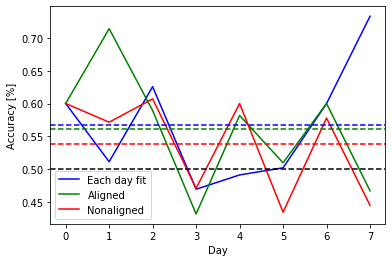

In [489]:
plotDaysAcc(diffDayAccList, alignedDayAccList, nonAlignedAccList, zeroAcc)

### Using Latent Space

In [490]:
dayZeroAccList = []
diffDayAccList = []
alignedDayAccList = []
nonAlignedAccList = []

# modelType = LinearDiscriminantAnalysis()
# modelType = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5)
modelType = RandomForestClassifier()

# Day Zero data arrangment
XZero = dictListStacked[0]['segmentedEEG']
XZero = AEmodel.encode(torch.Tensor(XZero)).detach().numpy()
XZero = np.reshape(XZero, (XZero.shape[0], XZero.shape[1] * XZero.shape[2]))
yZero = dictListStacked[0]['labels']

# Other days data arrangment
for dayIdx in range(1 ,len(EEGlist)):
    # Allign the data
    X = dictListStacked[dayIdx]['segmentedEEG']
    Xaligned = alignerList[dayIdx - 1](torch.Tensor(X)).detach().numpy()
    # latent Features exrtaction
    X = AEmodel.encode(torch.Tensor(X)).detach().numpy()
    Xaligned = AEmodel.encode(torch.Tensor(Xaligned)).detach().numpy()
    # Flatten the features
    X = np.reshape(X, (X.shape[0], X.shape[1] * X.shape[2]))
    Xaligned = np.reshape(Xaligned, (Xaligned.shape[0], Xaligned.shape[1] * Xaligned.shape[2]))
    # Labels
    y = dictListStacked[dayIdx]['labels']
    zeroAcc, diffAcc, alignedAcc, nonAlignedAcc = dayZeroCompare(XZero, yZero, X, Xaligned, y, modelType, eegInfo=eegInfo)
    dayZeroAccList.append(zeroAcc)
    diffDayAccList.append(diffAcc)
    alignedDayAccList.append(alignedAcc)
    nonAlignedAccList.append(nonAlignedAcc)

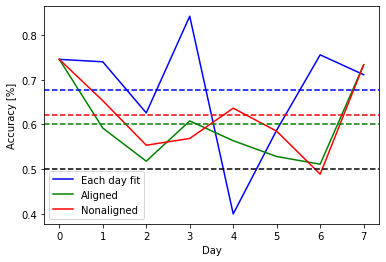

In [491]:
plotDaysAcc(diffDayAccList, alignedDayAccList, nonAlignedAccList, zeroAcc)

## Plots

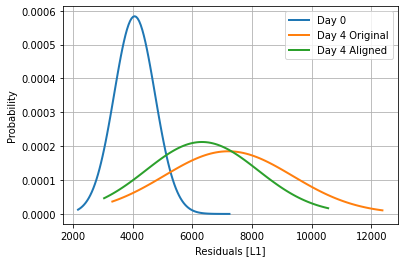

In [492]:
dayPlot = 4
plotAlignerDist(EEGlist, AEmodel, alignerList[dayPlot], dayPlot, distType=distType)

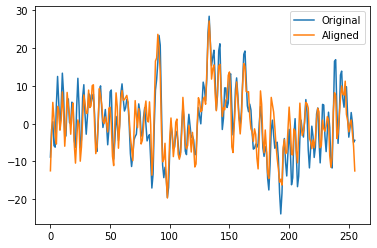

In [493]:
plotAlignedEEG(diffDayDataSet, alignerList[dayPlot - 1], 1, 1)

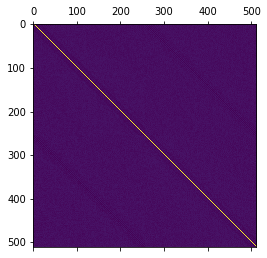

In [494]:
plt.matshow(alignerList[dayPlot].fc1.weight.detach().numpy())